## Setup

### Library Imports

In [2]:

import itertools
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp

from sklearn.metrics import auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

%matplotlib inline

### Define Constants

In [62]:
BATCH_SIZE = 32
CLASSES = ['adenosis', 'ductal_carcinoma', 'fibroadenoma', 'lobular_carcinoma', 'mucinous_carcinoma', 
            'papillary_carcinoma', 'phyllodes_tumor', 'tubular_adenoma']
CLASSES_BINARY = ['benign', 'malignant']
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
PARAMETER_FILE = 'RUN_SET.csv' # File containing parameters to run - results will be saved to same file
SEED = 42
TRAIN_SPLIT = 0.75
VAL_TEST_SPLIT = 0.6


### Dataset Creation

In [63]:
path_to_files = 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/'
  
train_dataset, holdout_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  labels = 'inferred',
  validation_split=(1-TRAIN_SPLIT),
  subset="both",
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True
)

holdout_batches = len(holdout_dataset)
val_size = int(holdout_batches*VAL_TEST_SPLIT)
test_size = int(holdout_batches*(1-VAL_TEST_SPLIT))

val_dataset = holdout_dataset.take(val_size)
test_dataset = holdout_dataset.skip(val_size).take(test_size)

print("Train dataset length: ", len(train_dataset))
print("Val dataset length: ", len(val_dataset))
print("Test dataset length: ", len(test_dataset))

# Use AUTOTUNE to decrease I/O roadblocks
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 7909 files belonging to 8 classes.
Using 5932 files for training.
Using 1977 files for validation.
Train dataset length:  186
Val dataset length:  37
Test dataset length:  24


## Model Definition and Training

### Model Definition

In [64]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
mobile_v3 = tf.keras.applications.MobileNetV3Large()  # load the model with pretrained weights

def data_augmenter():
    return tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    ])

def new_model (image_shape=IMG_SIZE, fine_tune_at=150):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                        include_top=False, # important
                                                        weights='imagenet')
    
    # freeze the base model
    base_model.trainable = True

    # freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # create input layer
    inputs = tf.keras.Input(shape=input_shape)
    # pre-process inputs
    x = preprocess_input(inputs)

    x = data_augmenter()(x)
    # set training to False to avoid tracking statistics in batch norm layer
    x = base_model(x, training=False)

    # add custom layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(8, activation='softmax')(x)

    outputs = x

    model = tf.keras.Model(inputs,outputs)
    return model

### Model Training

In [65]:
def train_model(model, train_dataset, val_dataset, params):

    # Unpack parameters
    num_epochs = params['num_epochs']
    lr = params['lr']
    epoch_decay = params['epoch_decay']

    steps_per_epoch = len(train_dataset)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr, decay_steps=steps_per_epoch, decay_rate=epoch_decay)

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule, momentum=0.95, nesterov=True)

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

    history = model.fit(
        train_dataset, 
        epochs=num_epochs,
        verbose=1,
        validation_data=val_dataset)

    return history

### Training Loop

Loop through the hyperparameters in the PARAMETER_FILE and train a model for each set of hyperparameters.

In [66]:
# Training loop

run_set = pd.read_csv(PARAMETER_FILE)

for index, row in run_set.iterrows():
    if pd.isna(row['T1']):
        print(f"Training model {index+1} of {len(run_set)}")
        print('-'*30)

        # Pack parameters
        params = {}
        params['num_epochs'] = int(row['num_epochs'])
        params['lr'] = row['lr']
        params['epoch_decay'] = row['epoch_decay']
        fine_tune_at = int(row['fine_tune_at'])

        # Create the model
        model = new_model(fine_tune_at=fine_tune_at)

        # Train the model
        history = train_model(model, train_dataset, val_dataset, params)

        # Write history to run set
        for epoch in range(params['num_epochs']):
            train_number = 'T' + str(epoch+1)
            run_set.at[index, train_number] = history.history['accuracy'][epoch]
            val_number = 'V' + str(epoch+1)
            run_set.at[index, val_number] = history.history['val_accuracy'][epoch]

        # Save the run set
        run_set.to_csv(PARAMETER_FILE, index=False)

        print('-'*30)
        print(f"Model {index+1} of {len(run_set)} trained and saved")
        print('-'*30)
        print()


Training model 74 of 74
------------------------------
Epoch 1/10
186/186 [==============================] - 324s 2s/step - loss: 1.6540 - accuracy: 0.4014 - val_loss: 1.4272 - val_accuracy: 0.5093
Epoch 2/10
186/186 [==============================] - 243s 1s/step - loss: 1.1290 - accuracy: 0.5912 - val_loss: 0.9398 - val_accuracy: 0.6461
Epoch 3/10
186/186 [==============================] - 289s 2s/step - loss: 0.7951 - accuracy: 0.7131 - val_loss: 0.8080 - val_accuracy: 0.6917
Epoch 4/10
186/186 [==============================] - 270s 1s/step - loss: 0.5912 - accuracy: 0.7928 - val_loss: 0.6126 - val_accuracy: 0.7796
Epoch 5/10
186/186 [==============================] - 330s 2s/step - loss: 0.4779 - accuracy: 0.8259 - val_loss: 0.5936 - val_accuracy: 0.7728
Epoch 6/10
186/186 [==============================] - 322s 2s/step - loss: 0.3358 - accuracy: 0.8791 - val_loss: 0.4721 - val_accuracy: 0.8218
Epoch 7/10
186/186 [==============================] - 376s 2s/step - loss: 0.2572 - acc

### Training Accuracy

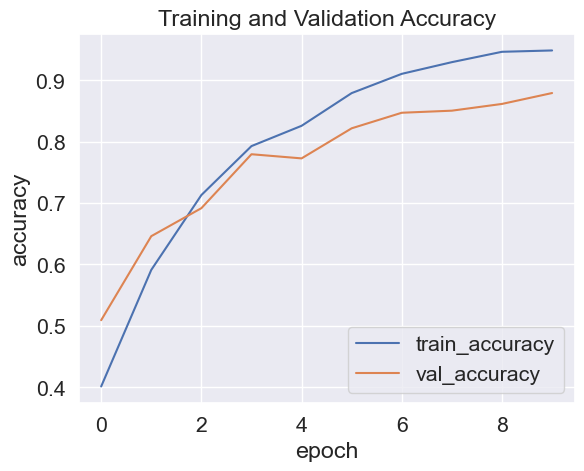

In [67]:
def plot_accuracy(train_accuracy, val_accuracy):
    # Plot the training and validation accuracy per epoch
    
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='val_accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

## Evaluation

### Collect Ground Truth and Generate Predictions

In [68]:
# Gather the ground truth from the train set
ytrain = []
for images, labels in train_dataset.map(lambda x, y: (x, y)):
    ytrain += labels.numpy().tolist()
ytrain_count = [ytrain.count(i) for i in range(len(CLASSES))]

# Get ground truth from test set
ytest = []
for images, labels in test_dataset.map(lambda x, y: (x, y)):
    ytest += labels.numpy().tolist()
y_binary_test = [i in [1, 3, 4, 5] for i in ytest]

# Get predictions from test set
ypred_raw = model.predict(test_dataset)
ypred = ypred_raw.argmax(axis=-1).tolist()
y_binary_pred = [i in [1, 3, 4, 5] for i in ypred]


24/24 [==============================] - 19s 554ms/step


### Confusion Matrices

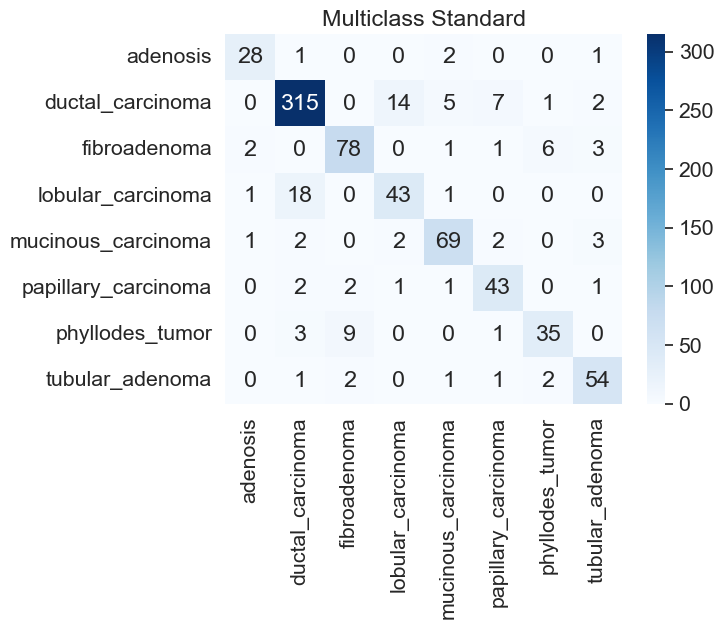

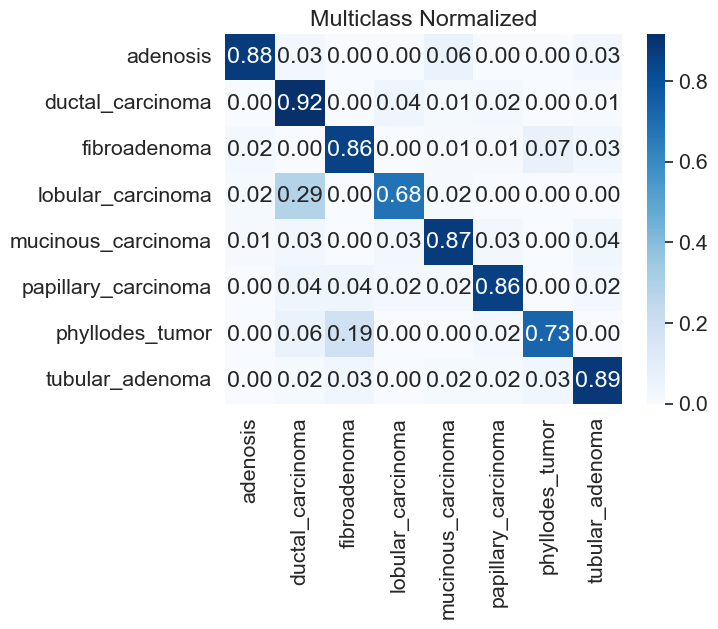

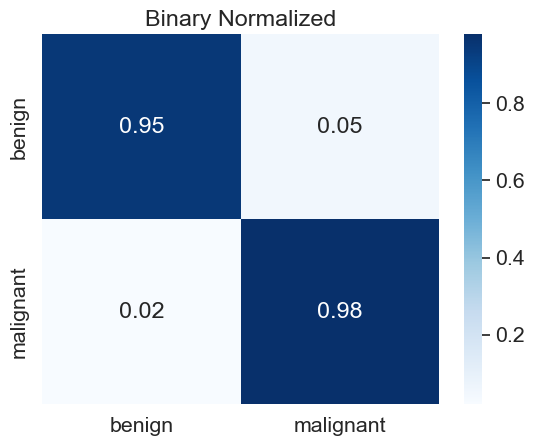

In [69]:
def generate_confusion_matrix(y_true, y_pred, classes, title, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    format = 'g'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        format = '.2f'
    sns.heatmap(cm, annot=True, fmt=format, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.show()

generate_confusion_matrix(ytest, ypred, CLASSES, 'Multiclass Standard', normalize=False)
generate_confusion_matrix(ytest, ypred, CLASSES, 'Multiclass Normalized', normalize=True)
generate_confusion_matrix(y_binary_test, y_binary_pred, CLASSES_BINARY, 'Binary Normalized', normalize=True)


### F1, Precision and Recall Scores

In [70]:
f1_score_all = f1_score(ytest, ypred, average=None)
precision_score_all = precision_score(ytest, ypred, average=None)
recall_score_all = recall_score(ytest, ypred, average=None)

# Compile the scores into a dataframe
scores_df = pd.DataFrame({'F1 score': f1_score_all, 'Precision score': precision_score_all, 'Recall score': recall_score_all, 'Count': ytrain_count}, index=CLASSES)
print(scores_df)

print("\nBenign vs Malignant Only:")
f1_score_binary = f1_score(y_binary_test, y_binary_pred)
print(f'F1: {f1_score_binary:.2f}')
precision_score_binary = precision_score(y_binary_test, y_binary_pred)
print(f'Precision: {precision_score_binary:.2f}')
recall_score_binary = recall_score(y_binary_test, y_binary_pred)
print(f'Recall: {recall_score_binary:.2f}')

                     F1 score  Precision score  Recall score  Count
adenosis             0.875000         0.875000      0.875000    345
ductal_carcinoma     0.918367         0.921053      0.915698   2576
fibroadenoma         0.857143         0.857143      0.857143    753
lobular_carcinoma    0.699187         0.716667      0.682540    468
mucinous_carcinoma   0.867925         0.862500      0.873418    594
papillary_carcinoma  0.819048         0.781818      0.860000    437
phyllodes_tumor      0.760870         0.795455      0.729167    331
tubular_adenoma      0.864000         0.843750      0.885246    428

Benign vs Malignant Only:
F1: 0.98
Precision: 0.98
Recall: 0.98


### ROC Curves

The following cells for generating the ROC curves were adapted from the following source:  
Zhang, C. (2018, April 21). Simple guide on how to generate ROC plot for Keras classifier. Medium; HackerNoon.com. https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a

In [77]:
lb = LabelBinarizer()
lb.fit(ytest)
ytest_lb = lb.transform(ytest)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(CLASSES)):
    fpr[i], tpr[i], _ = roc_curve(ytest_lb[:, i], ypred_raw[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytest_lb.ravel(), ypred_raw.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(CLASSES))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(CLASSES)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(CLASSES)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

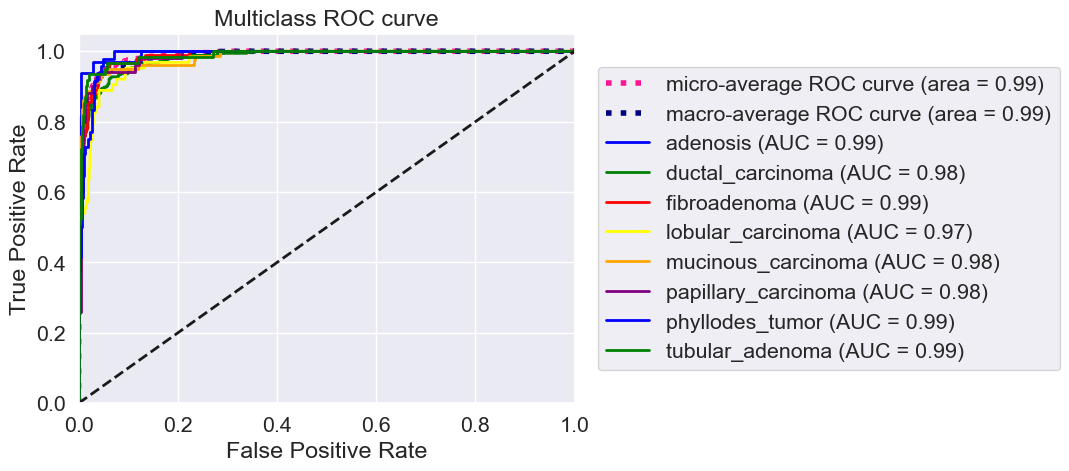

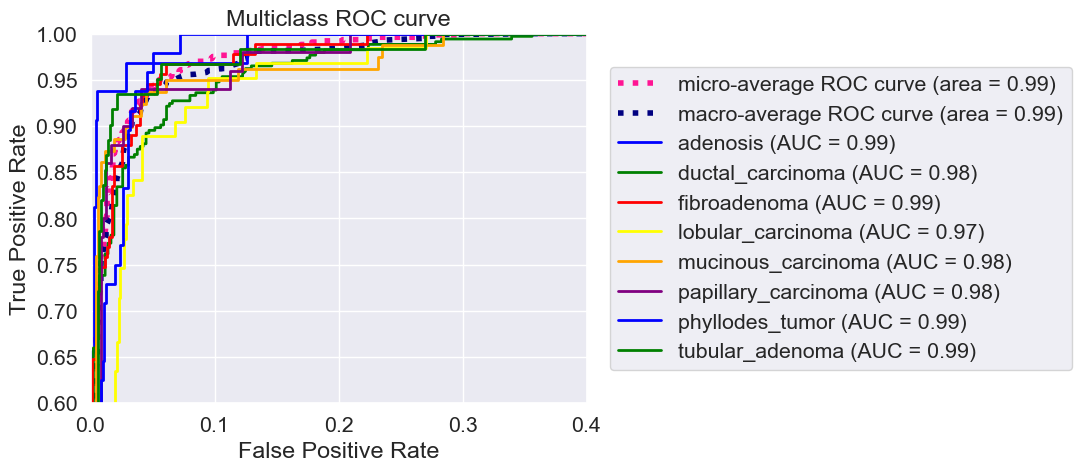

In [72]:

def plot_roc(fpr, tpr, roc_auc, classes, zoom=False):

      # Generate micro-average ROC curve plot
      plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

      # Generate macro-average ROC curve plot
      plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

      # Generate ROC curve for each class
      colors = cycle(['blue', 'green', 'red', 'yellow', 'orange', 'purple'])
      for i, color in zip(range(len(CLASSES)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                  label=f'{CLASSES[i]} (AUC = {roc_auc[i]:0.2f})')

      # Generate line for random guess
      plt.plot([0, 1], [0, 1], 'k--', lw=2)

      # Format and display plot
      if zoom:
            plt.xlim(0.0, 0.4)
            plt.ylim(0.6, 1.0)
      else:
            plt.xlim(0.0, 1.0)
            plt.ylim(0.0, 1.05)
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Multiclass ROC curve')
      if zoom:
            plt.legend(bbox_to_anchor=(2.0, 0.5), loc='center right')
      else:
            plt.legend(bbox_to_anchor=(2.0, 0.5), loc="center right")
      plt.show()

plot_roc(fpr, tpr, roc_auc, CLASSES, zoom=False)
plot_roc(fpr, tpr, roc_auc, CLASSES, zoom=True)

## Additional Tuning

### Data Augmentation

Study that shows the effect of data augmentation. Simple horizontal flips of the images during training reduced overfitting and improved validation accuracy.

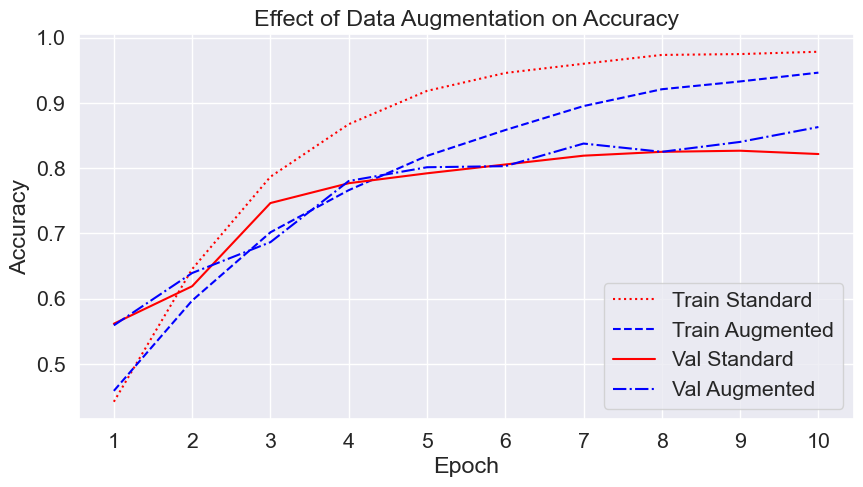

In [73]:
standard_row = 28
augmented_row = 29

train_standard = []
train_augmented = []
val_standard = []
val_augmented = []

# Collect data from the standard and augmented runs
for i in range(10):
    train_label = 'T' + str(i+1)
    val_label = 'V' + str(i+1)
    train_standard.append(run_set.iloc[standard_row][train_label])
    train_augmented.append(run_set.iloc[augmented_row][train_label])
    val_standard.append(run_set.iloc[standard_row][val_label])
    val_augmented.append(run_set.iloc[augmented_row][val_label])

# Plot the results
plt.figure(figsize=(10, 5))
x = np.arange(1, 11)
plt.plot(x, train_standard, label='Train Standard', color='red', linestyle=':')
plt.plot(x, train_augmented, label='Train Augmented', color='blue', linestyle='--')
plt.plot(x, val_standard, label='Val Standard', color='red', linestyle='-')
plt.plot(x, val_augmented, label='Val Augmented', color='blue', linestyle='-.')
plt.xticks(x)
plt.title('Effect of Data Augmentation on Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Layer Freezing

Study to determine the optimal layers to freeze for transfer learning. Fine tuning start layer represents the first layer that is unfrozen.

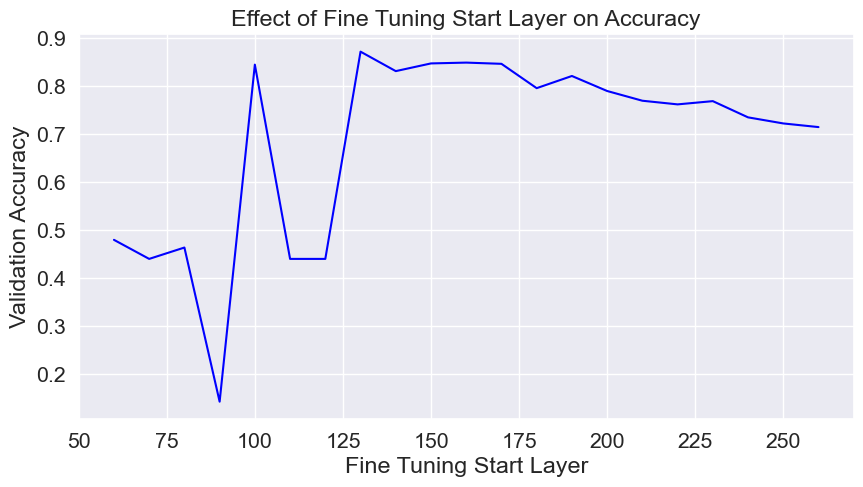

In [74]:
freeze_study_start = 40
freeze_study_end = 61

# Collect data from the fine tuning layer freeze runs
accuracy_scores = run_set.iloc[freeze_study_start:freeze_study_end]['V10'].tolist()
layer_starts = run_set.iloc[freeze_study_start:freeze_study_end]['fine_tune_at'].tolist()
accuracy_scores.reverse()
layer_starts.reverse()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(layer_starts, accuracy_scores, color='blue')
plt.title('Effect of Fine Tuning Start Layer on Accuracy')
plt.xlabel('Fine Tuning Start Layer')
plt.ylabel('Validation Accuracy')
plt.show()

### Learning Rate Selection

Study to determine the best initial learning rate and decay rate for the model.

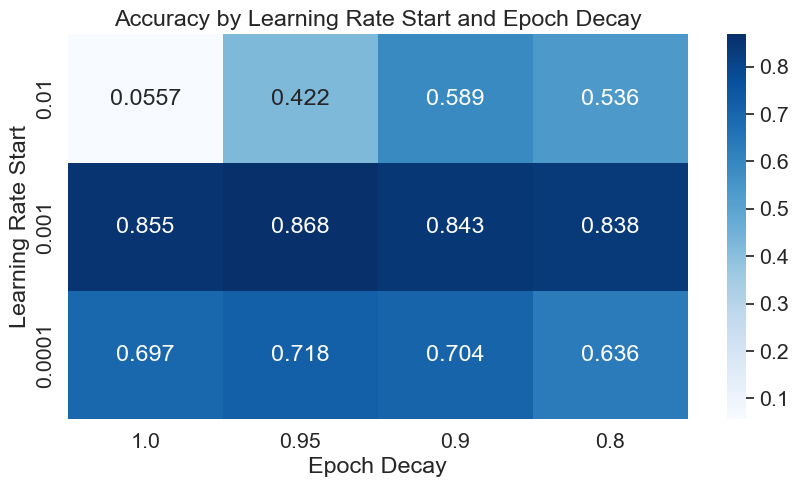

In [75]:
lr_study_start = 61
lr_study_end = 73

# Collect the results from the run set
lr_results_list = run_set.iloc[lr_study_start:lr_study_end]['V10'].tolist()
lr_results = np.reshape(lr_results_list, (3, 4))
epoch_decay_list = run_set.iloc[lr_study_start:lr_study_end]['epoch_decay'].tolist()
lr_start_list = run_set.iloc[lr_study_start:lr_study_end]['lr'].tolist()

# Get unique values from the epoch decay and lr_start lists
epoch_decay = sorted(list(set(epoch_decay_list)), reverse=True)
lr_start = sorted(list(set(lr_start_list)), reverse=True)

# Display the results in a heatmap
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(lr_results, annot=True, xticklabels=epoch_decay, yticklabels=lr_start, fmt='.3g', cmap='Blues', ax=ax)
ax.set_xlabel('Epoch Decay')
ax.set_ylabel('Learning Rate Start')
ax.set_title('Accuracy by Learning Rate Start and Epoch Decay')
plt.show()

## Misclassified Images

Samples first n number of requested misclassified images from the test set.

Actual:  ductal_carcinoma
Predicted:  lobular_carcinoma


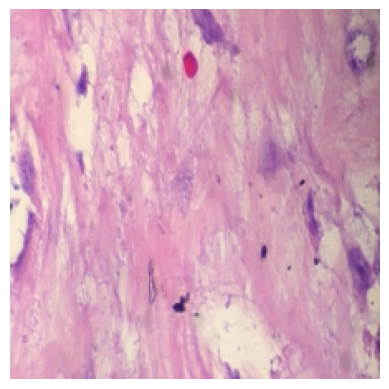

Actual:  fibroadenoma
Predicted:  phyllodes_tumor


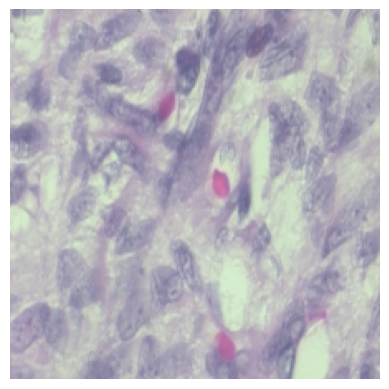

Actual:  fibroadenoma
Predicted:  phyllodes_tumor


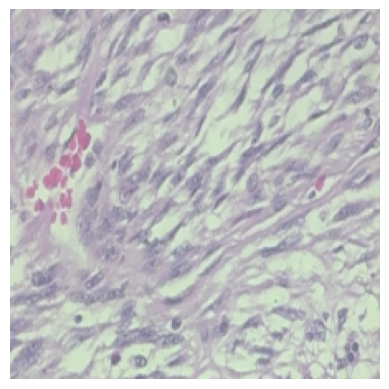

Actual:  adenosis
Predicted:  mucinous_carcinoma


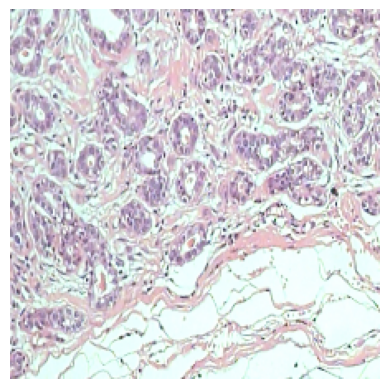

Actual:  lobular_carcinoma
Predicted:  ductal_carcinoma


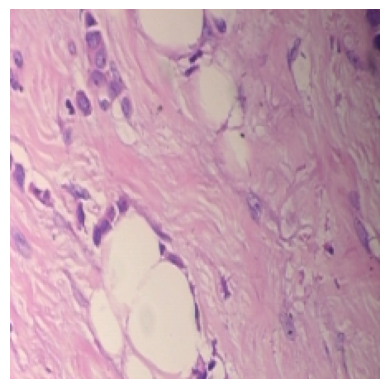

In [76]:
def display_misclassified(classes, ypred, ytest, test_dataset, requested=5):
    found = i = 0
    while found < requested and i < len(ypred):
        if ypred[i] != ytest[i]:
            found += 1

            batch_num = i // BATCH_SIZE
            image_num = i % BATCH_SIZE

            batch = test_dataset.skip(batch_num).take(1)
            for images, labels in batch:
                images = images
                labels = labels

            image = images[image_num].numpy()

            print("Actual: ", classes[labels[image_num]])
            print("Predicted: ", classes[ypred[i]])

            # Print the image from numpy array
            plt.imshow(image.astype("uint8"))
            plt.axis("off")
            plt.show()

        i += 1

display_misclassified(CLASSES, ypred, ytest, test_dataset)